# A6 - Student Layer Initialization
Name: Sitthiwat Damrongpreechar
<br>
Student ID: st123994

In [ ]:
#!pip install datasets

In [2]:
import datasets
import transformers
import torch
datasets.__version__, transformers.__version__, torch.__version__

('2.18.0', '4.38.2', '2.1.0+cu121')

In [3]:
import torch.nn as nn
import torch
from tqdm.auto import tqdm
import random, math, time

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

#make our work comparable if restarted the kernel
SEED = 1234
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

cuda


## 1. Loading our MNLI part of the GLUE dataset

In [4]:
import datasets

###1. Load Dataset
task_to_keys = {
    "cola": ("sentence", None),
    "mnli": ("premise", "hypothesis"),
    "mrpc": ("sentence1", "sentence2"),
    "qnli": ("question", "sentence"),
    "qqp": ("question1", "question2"),
    "rte": ("sentence1", "sentence2"),
    "sst2": ("sentence", None),
    "stsb": ("sentence1", "sentence2"),
    "wnli": ("sentence1", "sentence2"),
}

task_name = "mnli"
raw_datasets = datasets.load_dataset("glue", task_name)
raw_datasets

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/392702 [00:00<?, ? examples/s]

Generating validation_matched split:   0%|          | 0/9815 [00:00<?, ? examples/s]

Generating validation_mismatched split:   0%|          | 0/9832 [00:00<?, ? examples/s]

Generating test_matched split:   0%|          | 0/9796 [00:00<?, ? examples/s]

Generating test_mismatched split:   0%|          | 0/9847 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 392702
    })
    validation_matched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 9815
    })
    validation_mismatched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 9832
    })
    test_matched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 9796
    })
    test_mismatched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 9847
    })
})

In [5]:
label_list = raw_datasets['train'].features['label'].names
label2id = {v: i for i, v in enumerate(label_list)}
label2id

{'entailment': 0, 'neutral': 1, 'contradiction': 2}

In [6]:
id2label = {i: v for v, i in label2id.items()}
id2label

{0: 'entailment', 1: 'neutral', 2: 'contradiction'}

## 2. Model and Tokenization

In [7]:
import numpy as np
num_labels = np.unique(raw_datasets['train']['label']).size
num_labels

3

In [8]:
from transformers import AutoModelForSequenceClassification
from transformers import AutoTokenizer

teacher_id = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(teacher_id)

teacher_model = AutoModelForSequenceClassification.from_pretrained(
    teacher_id,
    num_labels = num_labels,
    id2label = id2label,
    label2id = label2id,
)

teacher_model

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

## 3. Preprocessing

In [9]:
def tokenize_function(examples):
    sentence1_key, sentence2_key = task_to_keys[task_name]
    args = (
        (examples[sentence1_key],) if sentence2_key is None else (examples[sentence1_key], examples[sentence2_key])
    )
    result = tokenizer(*args, max_length=128, truncation=True)
    return result

In [10]:
tokenized_datasets = raw_datasets.map(tokenize_function, batched=True)
tokenized_datasets

Map:   0%|          | 0/392702 [00:00<?, ? examples/s]

Map:   0%|          | 0/9815 [00:00<?, ? examples/s]

Map:   0%|          | 0/9832 [00:00<?, ? examples/s]

Map:   0%|          | 0/9796 [00:00<?, ? examples/s]

Map:   0%|          | 0/9847 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 392702
    })
    validation_matched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 9815
    })
    validation_mismatched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 9832
    })
    test_matched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 9796
    })
    test_mismatched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 9847
    })
})

In [11]:
# list(task_to_keys[task_name])
column_dataset = [item for item in task_to_keys[task_name] if item is not None]
column_dataset

['premise', 'hypothesis']

In [12]:
#remove column : 'premise', 'hypothesis', 'idx'
tokenized_datasets = tokenized_datasets.remove_columns(column_dataset + ["idx"])
#rename column : 'labels'
tokenized_datasets = tokenized_datasets.rename_column("label", "labels")
tokenized_datasets.set_format("torch")
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 392702
    })
    validation_matched: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 9815
    })
    validation_mismatched: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 9832
    })
    test_matched: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 9796
    })
    test_mismatched: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 9847
    })
})

In [13]:
tokenized_datasets['train'][0]['input_ids']

tensor([  101, 17158,  2135,  6949,  8301, 25057,  2038,  2048,  3937,  9646,
         1011,  4031,  1998, 10505,  1012,   102,  4031,  1998, 10505,  2024,
         2054,  2191,  6949,  8301, 25057,  2147,  1012,   102])

In [14]:
tokenizer.decode(tokenized_datasets['train'][0]['input_ids'])

'[CLS] conceptually cream skimming has two basic dimensions - product and geography. [SEP] product and geography are what make cream skimming work. [SEP]'

## 4. Preparing the Dataloader

In [15]:
from transformers import DataCollatorWithPadding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
#Data collator that will dynamically pad the inputs received.

In [16]:
small_train_dataset = tokenized_datasets["train"].shuffle(seed=1150).select(range(10000))
small_eval_dataset = tokenized_datasets["validation_mismatched"].shuffle(seed=1150).select(range(1000))
small_test_dataset = tokenized_datasets["test_mismatched"].shuffle(seed=1150).select(range(1000))

In [17]:
from torch.utils.data import DataLoader
train_dataloader = DataLoader(
    small_train_dataset, shuffle=True, batch_size=32, collate_fn=data_collator)
test_dataloader = DataLoader(
    small_test_dataset, batch_size=32, collate_fn=data_collator)
eval_dataloader = DataLoader(
    small_eval_dataset, batch_size=32, collate_fn=data_collator)

In [18]:

for batch in train_dataloader:
    break

batch['labels'].shape, batch['input_ids'].shape, batch['attention_mask'].shape

(torch.Size([32]), torch.Size([32, 121]), torch.Size([32, 121]))

## 5. Design the model and losses

### 5.1 Teacher Model & Student Model

In [19]:
teacher_model.config

BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "entailment",
    "1": "neutral",
    "2": "contradiction"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "contradiction": 2,
    "entailment": 0,
    "neutral": 1
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.38.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

In [20]:
from transformers.models.bert.modeling_bert import BertPreTrainedModel, BertConfig
# Get teacher configuration as a dictionnary
configuration = teacher_model.config.to_dict()
# configuration

In [21]:
# Half the number of hidden layer
configuration['num_hidden_layers'] //= 2
# Convert the dictionnary to the student configuration
configuration = BertConfig.from_dict(configuration)

In [22]:
# Create uninitialized student model
model = type(teacher_model)(configuration)
model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-5): 6 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, e

In [23]:
from transformers.models.bert.modeling_bert import BertEncoder, BertModel
from torch.nn import Module

def distill_bert_weights(
    teacher : Module,
    student : Module,
    layer_init= 'even',
) -> None:
    """
    Recursively copies the weights of the (teacher) to the (student).
    This function is meant to be first called on a BertFor... model, but is then called on every children of that model recursively.
    The only part that's not fully copied is the encoder, of which only half is copied.
    """
    # If the part is an entire BERT model or a BERTFor..., unpack and iterate
    if isinstance(teacher, BertModel) or type(teacher).__name__.startswith('BertFor'):
        for teacher_part, student_part in zip(teacher.children(), student.children()):
            distill_bert_weights(teacher_part, student_part)
    # Else if the part is an encoder, copy one out of every layer
    elif isinstance(teacher, BertEncoder):
        teacher_encoding_layers = [layer for layer in next(teacher.children())] #12 layers
        student_encoding_layers = [layer for layer in next(student.children())] #6 layers
        # Copy the weights of the teacher encoder to the student encoder
        if layer_init == 'even':
            for i in range(len(student_encoding_layers)):
                student_encoding_layers[i].load_state_dict(teacher_encoding_layers[2*i].state_dict())
        elif layer_init == 'odd':
            for i in range(len(student_encoding_layers)):
                student_encoding_layers[i].load_state_dict(teacher_encoding_layers[2*i+1].state_dict())
        elif layer_init == 'top':
            for i in range(len(student_encoding_layers)):
                student_encoding_layers[i].load_state_dict(teacher_encoding_layers[i].state_dict())
        elif layer_init == 'bottom':
            for i in range(len(student_encoding_layers)):
                student_encoding_layers[i].load_state_dict(teacher_encoding_layers[i+len(student_encoding_layers)].state_dict())

    # Else the part is a head or something else, copy the state_dict
    else:
        student.load_state_dict(teacher.state_dict())

    return model

In [24]:
even_model = distill_bert_weights(teacher=teacher_model, student=model)
odd_model = distill_bert_weights(teacher=teacher_model, student=model, layer_init='odd')
top_model = distill_bert_weights(teacher=teacher_model, student=model, layer_init='top')
bottom_model = distill_bert_weights(teacher=teacher_model, student=model, layer_init='bottom')

In [25]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print('Teacher parameters :', count_parameters(teacher_model))
print('Student parameters (Even Layers) :', count_parameters(even_model))
print('Student parameters (Odd Layers):', count_parameters(odd_model))
print('Student parameters (Top Layers):', count_parameters(top_model))
print('Student parameters (Bottom Layers):', count_parameters(bottom_model))

Teacher parameters : 109484547
Student parameters (Even Layers) : 66957315
Student parameters (Odd Layers): 66957315
Student parameters (Top Layers): 66957315
Student parameters (Bottom Layers): 66957315


In [26]:
print("Percentage of parameters (Even Layers) :",count_parameters(even_model)/count_parameters(teacher_model) * 100, "%")
print("Percentage of parameters (Odd Layers) :",count_parameters(odd_model)/count_parameters(teacher_model) * 100, "%")
print("Percentage of parameters (Top Layers) :",count_parameters(top_model)/count_parameters(teacher_model) * 100, "%")
print("Percentage of parameters (Bottom Layers) :",count_parameters(bottom_model)/count_parameters(teacher_model) * 100, "%")
#It has 40% less parameters than bert-base-uncased

Percentage of parameters (Even Layers) : 61.15686353435797 %
Percentage of parameters (Odd Layers) : 61.15686353435797 %
Percentage of parameters (Top Layers) : 61.15686353435797 %
Percentage of parameters (Bottom Layers) : 61.15686353435797 %


### 5.2 Loss function

In [27]:
import torch.nn.functional as F

class DistillKL(nn.Module):
    """
    Distilling the Knowledge in a Neural Network
    Compute the knowledge-distillation (KD) loss given outputs, labels.
    "Hyperparameters": temperature and alpha

    NOTE: the KL Divergence for PyTorch comparing the softmaxs of teacher
    and student expects the input tensor to be log probabilities!
    """

    def __init__(self):
        super(DistillKL, self).__init__()

    def forward(self, output_student, output_teacher, temperature=1):
        '''
        Note: the output_student and output_teacher are logits
        '''
        T = temperature #.cuda()

        KD_loss = nn.KLDivLoss(reduction='batchmean')(
            F.log_softmax(output_student/T, dim=-1),
            F.softmax(output_teacher/T, dim=-1)
        ) * T * T

        return KD_loss

In [28]:
criterion_div = DistillKL()
criterion_cos = nn.CosineEmbeddingLoss()

## 6. Optimizer

In [29]:
import torch.optim as optim
import torch.nn as nn

lr = 5e-5

#training hyperparameters
optimizer = optim.Adam(params=model.parameters(), lr=lr)

In [30]:
model = model.to(device)
teacher_model = teacher_model.to(device)

## 7. Learning rate scheduler

In [31]:
from transformers import get_scheduler

num_epochs = 5
num_update_steps_per_epoch = len(train_dataloader)
num_training_steps = num_epochs * num_update_steps_per_epoch

lr_scheduler = get_scheduler(
    name="linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps
)

In [32]:
def lr_scheduler_for_trained(optimizer, num_training_steps):
    scheduler = get_scheduler(
        name="linear",
        optimizer=optimizer,
        num_warmup_steps=0,
        num_training_steps=num_training_steps
    )
    return scheduler

## 8. Metric

In [ ]:
#!pip3 install evaluate

In [34]:
import numpy as np
import evaluate
# Get the metric function
if task_name is not None:
    metric = evaluate.load("glue", task_name)
else:
    metric = evaluate.load("accuracy")

## 9. Train the model

In [35]:
import torch
from tqdm.auto import tqdm

progress_bar = tqdm(range(num_training_steps))
eval_metrics = 0
model_layers = ['even', 'odd','top', 'bottom']
model_layers_scores = {}

for layer in model_layers:
    print(f"Training {layer} layers")
    # Lists to store losses for each epoch
    train_losses = []
    train_losses_cls = []
    train_losses_div = []
    train_losses_cos = []
    eval_losses = []
    # Model's layer to be trained
    model = type(teacher_model)(configuration)
    model = distill_bert_weights(teacher=teacher_model, student=model, layer_init=layer)
    model = model.to(device)
    model_layers_scores[layer] = {}
    #training hyperparameters
    optimizer = optim.Adam(params=model.parameters(), lr=lr)
    lr_scheduler = lr_scheduler_for_trained(optimizer, num_training_steps)
    for epoch in range(num_epochs):
        model.train()
        teacher_model.eval()
        train_loss = 0
        train_loss_cls = 0
        train_loss_div = 0
        train_loss_cos = 0

        for batch in train_dataloader:
            batch = {k: v.to(device) for k, v in batch.items()}
            # compute student output
            outputs = model(**batch)
            # compute teacher output
            with torch.no_grad():
                output_teacher = teacher_model(**batch)

            # assert size
            assert outputs.logits.size() == output_teacher.logits.size()

            # cls loss
            loss_cls  = outputs.loss
            train_loss_cls += loss_cls.item()
            # distillation loss
            loss_div = criterion_div(outputs.logits, output_teacher.logits)
            train_loss_div += loss_div.item()
            # cosine loss
            loss_cos = criterion_cos(output_teacher.logits, outputs.logits, torch.ones(output_teacher.logits.size()[0]).to(device))
            train_loss_cos += loss_cos.item()

            # Average the loss and return it
            loss = (loss_cls + loss_div + loss_cos) / 3

            train_loss += loss.item()
            loss.backward()
            # accelerator.backward(loss)
            # Step with optimizer
            optimizer.step()
            lr_scheduler.step()
            optimizer.zero_grad()
            progress_bar.update(1)

        train_losses.append(train_loss / len(train_dataloader))
        train_losses_cls.append(train_loss_cls / len(train_dataloader))
        train_losses_div.append(train_loss_div / len(train_dataloader))
        train_losses_cos.append(train_loss_cos / len(train_dataloader))


        print(f'Epoch at {epoch+1}: Train loss {train_loss/len(train_dataloader):.4f}:')
        print(f'  - Loss_cls: {train_loss_cls/len(train_dataloader):.4f}')
        print(f'  - Loss_div: {train_loss_div/len(train_dataloader):.4f}')
        print(f'  - Loss_cos: {train_loss_cos/len(train_dataloader):.4f}')

        model.eval()
        eval_loss = 0
        for batch in eval_dataloader:
            batch = {k: v.to(device) for k, v in batch.items()}
            with torch.no_grad():
                outputs = model(**batch)

            loss_cls = outputs.loss
            predictions = outputs.logits.argmax(dim=-1)

            eval_loss += loss_cls.item()
            # predictions, references = accelerator.gather((predictions, batch["labels"]))
            metric.add_batch(
                predictions=predictions,
                references=batch["labels"])

        eval_metric = metric.compute()
        eval_metrics += eval_metric['accuracy']
        eval_losses.append(eval_loss / len(eval_dataloader))  # Save the evaluation loss for plotting

        model_layers_scores[layer]['train_losses'] = train_losses
        model_layers_scores[layer]['train_losses_cls'] = train_losses_cls
        model_layers_scores[layer]['train_losses_div'] = train_losses_div
        model_layers_scores[layer]['train_losses_cos'] = train_losses_cos
        model_layers_scores[layer]['accuracy'] = eval_metric['accuracy']
        model_layers_scores[layer]['eval_losses'] = eval_losses

        print(f"Epoch at {epoch+1}: Test Acc {eval_metric['accuracy']:.4f}")

    print('Avg Metric', eval_metrics/num_epochs)
    model_layers_scores[layer]['avg_metric'] = eval_metrics/num_epochs

  0%|          | 0/1565 [00:00<?, ?it/s]

Training even layers
Epoch at 1: Train loss 0.3594:
  - Loss_cls: 0.9857
  - Loss_div: 0.0424
  - Loss_cos: 0.0502
Epoch at 1: Test Acc 0.6200
Epoch at 2: Train loss 0.3136:
  - Loss_cls: 0.7864
  - Loss_div: 0.1064
  - Loss_cos: 0.0481
Epoch at 2: Test Acc 0.6540
Epoch at 3: Train loss 0.2764:
  - Loss_cls: 0.6228
  - Loss_div: 0.1574
  - Loss_cos: 0.0492
Epoch at 3: Test Acc 0.6560
Epoch at 4: Train loss 0.2543:
  - Loss_cls: 0.5247
  - Loss_div: 0.1890
  - Loss_cos: 0.0493
Epoch at 4: Test Acc 0.6740
Epoch at 5: Train loss 0.2450:
  - Loss_cls: 0.4836
  - Loss_div: 0.2025
  - Loss_cos: 0.0489
Epoch at 5: Test Acc 0.6750
Avg Metric 0.6557999999999999
Training odd layers
Epoch at 1: Train loss 0.3581:
  - Loss_cls: 0.9809
  - Loss_div: 0.0437
  - Loss_cos: 0.0498
Epoch at 1: Test Acc 0.6240
Epoch at 2: Train loss 0.3128:
  - Loss_cls: 0.7847
  - Loss_div: 0.1058
  - Loss_cos: 0.0479
Epoch at 2: Test Acc 0.6680
Epoch at 3: Train loss 0.2758:
  - Loss_cls: 0.6202
  - Loss_div: 0.1585
  

In [36]:
print(model_layers_scores)

{'even': {'train_losses': [0.35944743249743893, 0.31359911840944626, 0.27644862001315473, 0.2543210642406354, 0.24500311349337092], 'train_losses_cls': [0.98573560836597, 0.7863671779632568, 0.622825384520875, 0.524679061037283, 0.483572415460032], 'train_losses_div': [0.042391527152528016, 0.10635149487243674, 0.1573525617916744, 0.1890297101233333, 0.20249068970306994], 'train_losses_cos': [0.05021512580993838, 0.048078655375364106, 0.04916788598956963, 0.049254399435683945, 0.04894621474460101], 'accuracy': 0.675, 'eval_losses': [0.9014467373490334, 0.8453643247485161, 0.8287895135581493, 0.8172688782215118, 0.813284320756793], 'avg_metric': 0.6557999999999999}, 'odd': {'train_losses': [0.35813539496625957, 0.31279367294174415, 0.2758085400627825, 0.2560548147263999, 0.24651385353396113], 'train_losses_cls': [0.9809480052405652, 0.784720828548407, 0.6202350043641112, 0.531716624578348, 0.4901828838232607], 'train_losses_div': [0.043680484906529274, 0.1057679146742478, 0.158504068827

In [37]:
model_layers

['even', 'odd', 'top', 'bottom']

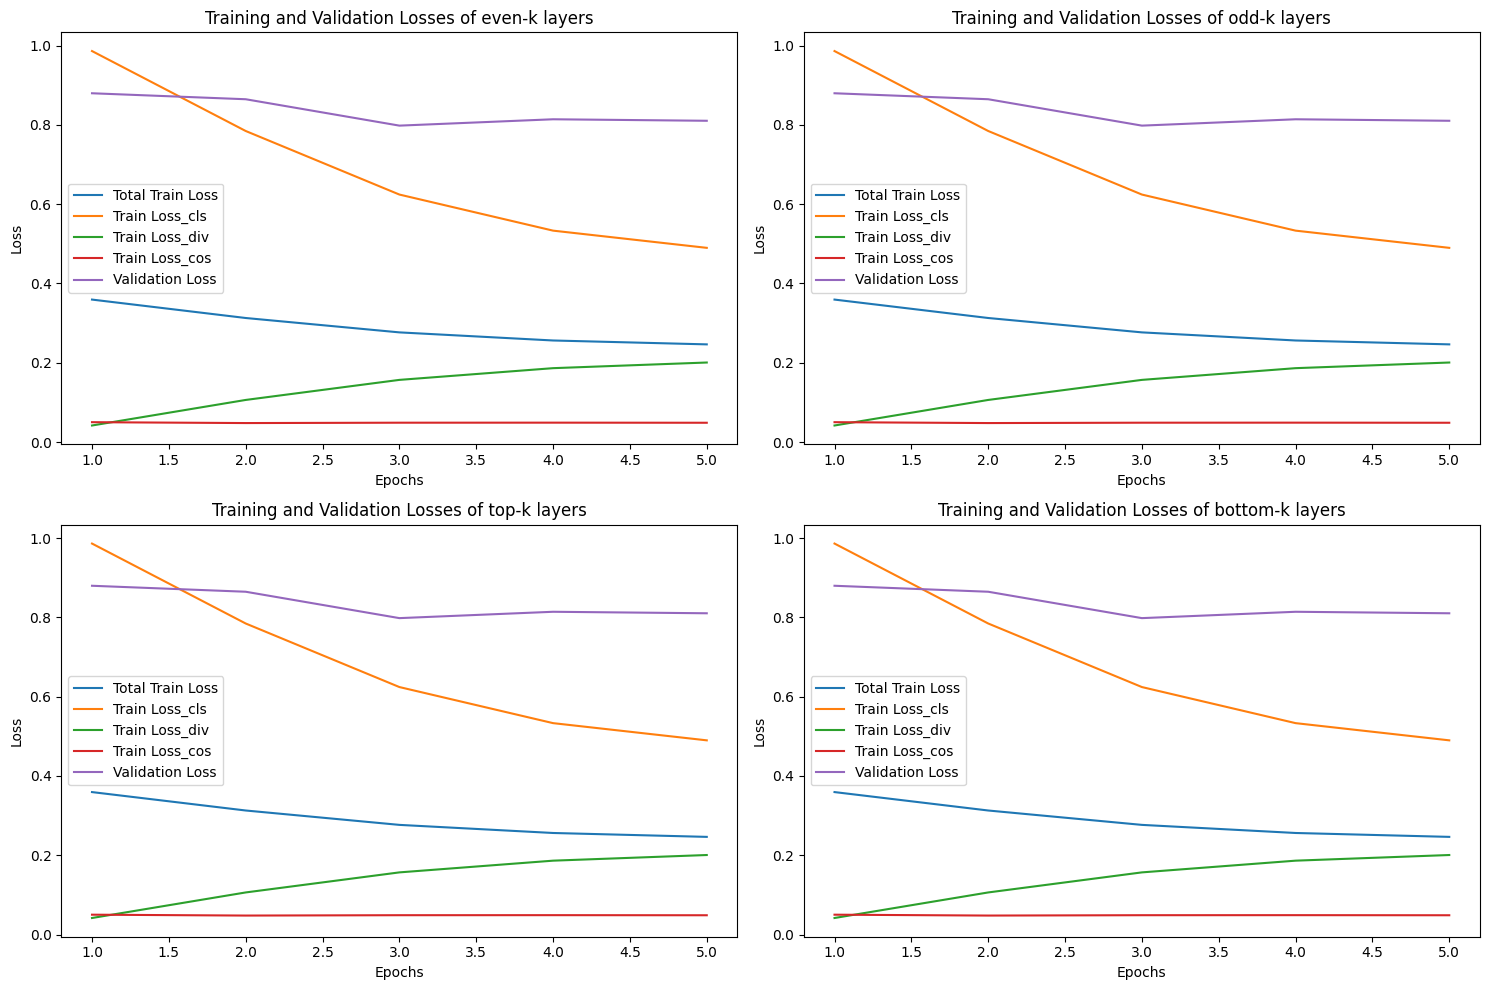

In [38]:
import matplotlib.pyplot as plt
# Plotting
epochs_list = range(1, num_epochs + 1)
num_rows, num_cols = 2,2
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 10))
for idx, ax in enumerate(axes.flat):
    m = model_layers[idx]
    ax.plot(epochs_list, train_losses, label='Total Train Loss')
    ax.plot(epochs_list, train_losses_cls, label='Train Loss_cls')
    ax.plot(epochs_list, train_losses_div, label='Train Loss_div')
    ax.plot(epochs_list, train_losses_cos, label='Train Loss_cos')
    ax.plot(epochs_list, eval_losses, label='Validation Loss')
    ax.set_title(f'Training and Validation Losses of {m}-k layers')
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    ax.legend()

# Adjust layout
plt.tight_layout()
plt.show()

In [46]:
# For markdown table
# Header
markdown_table = "| Layer | Train Loss | Validation Loss | Accuracy |\n"
markdown_table += "| --- | --- | --- | --- |\n"

# Rows
for layer, metrics in model_layers_scores.items():
    train_losses = metrics['train_losses']
    eval_losses = metrics['eval_losses']
    accuracy = metrics['accuracy']
    row = f"| {layer} | {train_losses[-1]:.6f} | {eval_losses[-1]:.6f} | {accuracy:.6f} |\n"
    markdown_table += row

print(markdown_table)

| Layer | Train Loss | Validation Loss | Accuracy |
| --- | --- | --- | --- |
| even | 0.245003 | 0.813284 | 0.675000 |
| odd | 0.246514 | 0.798235 | 0.683000 |
| top | 0.247091 | 0.808383 | 0.679000 |
| bottom | 0.246424 | 0.810205 | 0.670000 |



| Layer | Train Loss | Validation Loss | Accuracy  |
| --- | --- | --- | --- |
| Even Layer | 0.245003 | 0.813284 | 0.675000 |
| Odd Layer | 0.246514 | 0.798235 | 0.683000 |
| Top-K Layer | 0.247091 | 0.808383 | 0.679000 |
| Bottom-K Layer | 0.246424 | 0.810205 | 0.670000 |

### Analysis of Initial Layer Selection Impact

- **Even Layer**: Achieved the lowest training loss but with a relatively lower accuracy compared to the odd layer model.
- **Odd Layer**: Slightly higher training loss than even layer model but achieved a slightly lower validation loss and higher accuracy.
- **Top-K Layer**: Performance was in between even and odd layer models, with moderate training and validation losses.
- **Bottom-K Layer**: Similar performance to the even layer model but slightly lower accuracy.

The choice of initial layer selection impacts the performance of the distilled student model. In this case, different layer selection strategies resulted in varying training and validation losses as well as accuracy.

### Limitations and Challenges Encountered

- Low Number of Epochs: The model was trained for only a short period due to limited computing resources or time constraints. This could mean the model didn't have enough time to fully learn from the data, resulting in potentially subpar accuracy. Increasing the training time (epochs) could help the model learn more complex patterns and perform better overall, but this might require more computational power and time.

### Potential Improvements and Modifications

- Training on the cloud can improve performance by providing access to scalable computing resources, allowing for longer training durations and handling larger datasets, thus mitigating the limitations imposed by low computational power.
- Investigate reinforcement learning or automated methods for dynamic layer selection.
- Investigate the impact of layer selection on specific performance metrics or downstream tasks to gain deeper insights into the effectiveness of different strategies.
